# Extract RVs from FEROS HRS spectra



In [17]:
from scipy import interpolate
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import polyval
import importlib as impl
import copy
import math
import glob, os
from astropy.io import fits
import astropy.units as u
import fnmatch
from astropy.modeling.polynomial import Chebyshev1D,Polynomial1D
from astropy.table import Table
import numpy as np
from scipy.signal import savgol_filter
from astropy.time import Time

import matplotlib.pyplot as plt
%matplotlib inline 
c = 2.99792458e8  # m/s

In [18]:
# input reduced, wavelength calibrated (BC removed), normalized spectra

target_name='HD 81797'
odir = f'./feros/{target_name}/'
ofiles = fnmatch.filter(os.listdir(odir),"*.dat")

folder_name = os.path.basename(os.path.normpath(odir))
save_file_name = folder_name + 'rv.npz'



In [19]:
# List storing all spectra omat = nspec *[wavelength flux order]
omat = []
for file in ofiles:
    otab = Table.read(odir+file,format='ascii')
    omat.append(otab)
#print(len(omat))

In [20]:
# function for extracting the spectra of all orders
def get_ordspec(omat, order):
    nspec = len(omat)
    ordwav = []
    ordspec = []
    for i in range(nspec):
        ordind = np.where(omat[i]['Order'] == order)[0]
        thiswav = omat[i]['Wavelength'][ordind]
        thisflux = omat[i]['Flux_normalized'][ordind]
        ordwav.append(thiswav)
        ordspec.append(thisflux)
        
    return ordwav, ordspec

In [21]:
## function for stacking an order
"""
using one wavelength of one order to stack all spectra from different observes 
delw is set to 1/4 of the wavelength difference empirically
##########
"""
padding = 5.0
smooth_rv = 2e4  # smoothing window in m/s
def stack_ord(ordwav, ordspec):
    wav0 = np.min(ordwav) + padding # pad some angstroms
    wav1 = np.max(ordwav) - padding
    delw = np.abs(np.median(ordwav[0][0:-1]-ordwav[0][1:]))
    delw /= 4.0 # over sample by a factor of 4
    wavearr = np.arange(wav0,wav1,delw) ## new wavearr shape = 4* wavelength of the initial order
    fluxmat = np.zeros((len(wavearr),len(ordwav)))
    # loop through spectra
    for i in range(len(ordwav)):
        ord_interp = interpolate.interp1d(ordwav[i],ordspec[i],kind='linear')
        ord_flux = ord_interp(wavearr)
        fluxmat[:,i] = ord_flux
    
    fluxarr = np.mean(fluxmat,axis=1)
            
    sm_order = 1
    sm_window = int(smooth_rv/c*np.median(wavearr)/delw)
    sm_fluxarr = savgol_filter(fluxarr, sm_window, sm_order)
    
    return wavearr, fluxarr, sm_fluxarr, fluxmat

In [25]:
ordwav,ordspec = get_ordspec(omat,10)  #ordwav is nspec * [wavelength] of order xx 
### note that if you use get_orders.py to cut the orders from FEROS orders should start by 5
print(len(ordwav),len(ordspec))# 56 is an order with a big line
wavearr,fluxarr,sm_fluxarr,fluxmat = stack_ord(ordwav,ordspec)

6 6


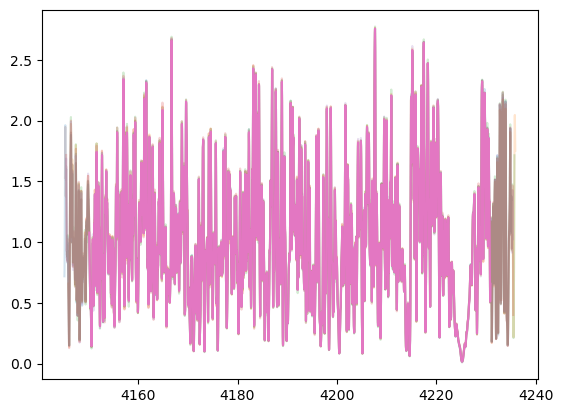

In [26]:
for i in range(len(ordwav)):
    plt.plot(ordwav[i],ordspec[i],alpha=0.2)
#plt.plot(wavearr,np.median(fluxmat,axis=1)) # bad
plt.plot(wavearr,fluxarr)
#plt.plot(wavearr,sm_fluxarr)
#plt.xlim((5160,5180))
#plt.ylim((0.8,1.05))

In [27]:
# basic CCF
def interp_min(vgrid, corrvalue):
    # use interpolation to get the min of CCF (plot the RV CCF plot)
    # returns just the RV
    corr_interp = interpolate.splrep(vgrid, corrvalue, s=0)
    vgrid1side = np.linspace(1, 3e4, num=30000)  # many times more than original
    # vgrid1side - starting small to avoid digitization for early chunks at 1 cm/s level
    vgrid_rs = np.concatenate((np.flipud(vgrid1side) * (-1.0), np.zeros(1), vgrid1side)) #Flip vgrid1side then join it with zero and the original vgrid1side to form a symmetric velocity grid vgrid_rs
    corrvalue_rs = interpolate.splev(vgrid_rs, corr_interp, der=0)
    minarg = np.argmin(corrvalue_rs)

    return vgrid_rs[minarg]

def ccf_basic(obs, model, weight=False, tplmask=False):
    # for a chunk of spectrum, returns RV from cross correlation
    # the most basic version - no dividing out tellurics
    # assuming obs and model on different wavelength grids
    #vgrid1side = np.logspace(-1, np.log10(3e4), num=100)  # Very precise! All at 0 cm/s for validate_ccf.py
    vgrid1side = np.linspace(1, 3e4, num=3000)  # customized for SPIRou data
    vgrid = np.concatenate((np.flipud(vgrid1side) * (-1.0), np.zeros(1), vgrid1side))
    #vgrid = np.linspace(-8000, 8000, num=2001) + bc  # in m/s
    corrvalue = np.zeros(len(vgrid))
    syn_interp = interpolate.interp1d(model['wave'], model['flux'], kind='cubic')  # keep cubic throughout

    # if having a preserved mask from template making, then mask out bad template pixels as well
    if tplmask:
        mask_interp = interpolate.interp1d(model['wave'], model['mask']*1.0, kind='linear')
    
    padding = 1  # chop off edge, just 50 pixels on each side; remember already hundreds of pixels were chopped off
    
    # determine wavelength range to use, customized for SPIRou orders
    minwave = np.max([np.nanmin(obs['wave']), np.nanmin(model['wave'])])
    maxwave = np.min([np.nanmax(obs['wave']), np.nanmax(model['wave'])])
    wuse = np.where((obs['wave'] < (maxwave - padding)) & (obs['wave'] >= (minwave + padding)))[0]

    for i, rv in enumerate(vgrid):
        # not convolving the model spectrum
        # I'm guessing convolving it with the perfectly known PSF will produce a more precise result (narrower CCF)
        # But the Baranne paper does not convolve their stellar mask, obviously
        mwaveshift = obs['wave'][wuse] / (1.0 + rv / c) #symbol only effect rv's symbol
        mspecshift = syn_interp(mwaveshift)
        if tplmask:
                mask_ind = np.where(mask_interp(mwaveshift) > 0.5)[0]  # again, 1 is bad, set threshold at 0.5, the same as mktpl530.py
                mspecshift[mask_ind] = np.NaN  # set to NaN, equivalent of 0 weight in CCF
        if weight:
            thiswt = obs['ivar'][wuse] # can't calculate ivar because FEROS has no flux errors
            if tplmask:
                thiswt[mask_ind] = 0.0  # need to adjust the weight!
            corrvalue[i] = np.nansum((mspecshift - obs['flux'][wuse]) ** 2 * thiswt)/np.nansum(thiswt)
        else:
            corrvalue[i] = np.nansum((mspecshift - obs['flux'][wuse]) ** 2)
        # value of cross correlation, Eqn. 8 of Baranne el al. 1996
        # Actually, must use (a-b)**2 instead of a*b, because the model spectrum does shift in and out
        # of the observed spectrum wavelength window!! SXW Oct 2018

    best_rv = interp_min(vgrid, corrvalue)

    return best_rv, vgrid, corrvalue

In [28]:
# build the obs and model objects needed to feed CCF

# which spectral file to use?
cut_edge = padding+1.0 # cut 1 angstrom more compared to the model
def build_obs(ordwav,ordspec,ifile):
    thiswave = ordwav[ifile] ##use num ifile's selected order 
    w0 = np.min(thiswave) + cut_edge
    w1 = np.max(thiswave) - cut_edge
    use_ind = np.where((thiswave > w0) & (thiswave < w1))[0]
    obs = np.zeros(len(use_ind),dtype={'names': ('wave', 'flux'), 'formats': ('f8', 'f8')})
    obs['wave'] = thiswave[use_ind]
    obs['flux'] = ordspec[ifile][use_ind]
    
    return obs

# fluxarr can be the smoothed or the original mean flux
def build_mod(wavearr,fluxarr):
    mod = np.zeros(len(wavearr),dtype={'names': ('wave', 'flux'), 'formats': ('f8', 'f8')})
    mod['wave'] = wavearr
    mod['flux'] = fluxarr
    
    return mod

In [29]:
ordwav,ordspec = get_ordspec(omat,10)
#print(ordwav,ordspec,len(ordwav),len(ordspec))
#print(wavearr)
obs = build_obs(ordwav,ordspec,1)
#print(obs)
#print(len(obs))
mod = build_mod(wavearr,fluxarr)


In [30]:
best_rv,vgrid,corrvalue = ccf_basic(obs,mod)

-59.0


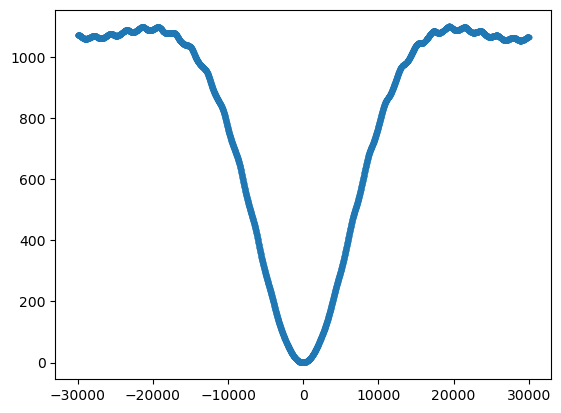

In [31]:
plt.plot(vgrid,corrvalue,'.')
#plt.xlim((-10000,10000))
print(best_rv)

In [32]:
# Get the RV matrix for all orders and all spectra
ordwav,ordspec = get_ordspec(omat,0)  # grab one first to see how many orders we have
nord = np.unique(omat[i]['Order']).size
nspec = len(ofiles)
rvmat = np.zeros((nord, nspec))
#print(nord,nspec,rvmat.shape)

In [33]:
tplwave = []
tplflux = []
tplsmf = []
for i in range(nord): ## to get the rv matrix

    ordwav,ordspec = get_ordspec(omat,i+5) ##i+5 because order start from 5 after cutting from get_orders.py this step gets all orders
    #print(ordwav,ordspec,len(ordwav),len(ordspec))
    # build and save the template
    wavearr,fluxarr,sm_fluxarr,fluxmat = stack_ord(ordwav,ordspec)
    tplwave.append(wavearr)
    tplflux.append(fluxarr)
    tplsmf.append(sm_fluxarr)
    for j in range(nspec): # i+5th order j date
        obs = build_obs(ordwav,ordspec,j)
        mod = build_mod(wavearr,fluxarr)
        best_rv,vgrid,corrvalue = ccf_basic(obs,mod)
        rvmat[i,j] = best_rv
        print(i,j,best_rv)

0 0 -220.0
0 1 -315.0
0 2 42.0
0 3 -577.0
0 4 145.0
0 5 -84.0
1 0 -30.0
1 1 -75.0
1 2 6.0
1 3 -363.0
1 4 252.0
1 5 -20.0
2 0 -8.0
2 1 -63.0
2 2 63.0
2 3 -264.0
2 4 224.0
2 5 -9.0
3 0 -25.0
3 1 -57.0
3 2 66.0
3 3 -226.0
3 4 246.0
3 5 12.0
4 0 -41.0
4 1 -55.0
4 2 61.0
4 3 -207.0
4 4 260.0
4 5 10.0
5 0 -53.0
5 1 -59.0
5 2 67.0
5 3 -200.0
5 4 274.0
5 5 12.0
6 0 -54.0
6 1 -55.0
6 2 64.0
6 3 -197.0
6 4 264.0
6 5 18.0
7 0 -64.0
7 1 -59.0
7 2 71.0
7 3 -197.0
7 4 280.0
7 5 19.0
8 0 -72.0
8 1 -56.0
8 2 70.0
8 3 -220.0
8 4 307.0
8 5 20.0
9 0 -79.0
9 1 -49.0
9 2 70.0
9 3 -211.0
9 4 312.0
9 5 16.0
10 0 -92.0
10 1 -55.0
10 2 76.0
10 3 -212.0
10 4 328.0
10 5 10.0
11 0 -102.0
11 1 -61.0
11 2 87.0
11 3 -214.0
11 4 349.0
11 5 4.0
12 0 -91.0
12 1 -57.0
12 2 80.0
12 3 -219.0
12 4 340.0
12 5 8.0
13 0 -104.0
13 1 -59.0
13 2 85.0
13 3 -218.0
13 4 342.0
13 5 5.0
14 0 -114.0
14 1 -62.0
14 2 89.0
14 3 -210.0
14 4 334.0
14 5 13.0
15 0 -112.0
15 1 -51.0
15 2 83.0
15 3 -209.0
15 4 340.0
15 5 -1.0
16 0 -121.0
16 1 

In [34]:
np.median(rvmat,axis=1)
#print(rvmat)
print(np.mean(rvmat[0,:]))
print(rvmat[1,:])

-168.16666666666666
[ -30.  -75.    6. -363.  252.  -20.]


In [50]:
def vank(rvmat,simple=False,outlier=False):
    # return weighted averaged RVs through a simple vanking with no outlier rejection

    nords = np.shape(rvmat)[0]
    nfiles = np.shape(rvmat)[1]

    rvmat_old = copy.deepcopy(rvmat)  # well this did nothing; still modified rvmat
    
    # mean of each order across nights should be set to 0, all shift to 0
    for iord in range(nords):
        rvmat[iord,:] = rvmat[iord,:] - np.mean(rvmat[iord,:]) # 
    #print(rvmat)
    # Next, variance of each order
    rvmed = np.median(rvmat,axis=0)  # median RV of all chunks of each night
    rvmarr = np.repeat(rvmed,nords)
    rvmarr = np.transpose(np.reshape(rvmarr,(nfiles,nords)))

    drv = np.abs(rvmat - rvmarr)  # Delta_ij in thesis equation 2.8
    #print(drv)
    if simple:
        drv_median = np.median(drv, axis=1)
        ord_wt = 1.0/drv_median**2
        wrv = np.dot(np.transpose(rvmat),ord_wt)/np.sum(ord_wt)
        rverr = np.std(rvmat,axis=0)/np.sqrt(nfiles)
        wij = 0
    elif outlier:
        sigmai = np.std(drv,axis=1)  # weight of each chunk
        print(sigmai)
        # Outlier rejection based on sigmai
        median_sigmai = np.median(sigmai)
        mad_sigmai = np.median(np.abs(sigmai - median_sigmai))
        lower_threshold = median_sigmai - 3 * mad_sigmai
        upper_threshold = median_sigmai + 3 * mad_sigmai
        #print(lower_threshold,upper_threshold)    
        outlier_mask_sigmai = (sigmai < lower_threshold) | (sigmai > upper_threshold)
        sigmai[outlier_mask_sigmai] = np.nan

        
        valid_orders = ~np.isnan(sigmai)
        sigmai = sigmai[valid_orders] #remove outiler sigmai order
        drv = drv[valid_orders, :]
        rvmat = rvmat[valid_orders, :]
        
        sigmamat = np.repeat(sigmai,nfiles)
        sigmamat = np.reshape(sigmamat,(len(sigmai),nfiles))
        #sigmamat = np.reshape(sigmamat,(nords,nfiles))
        #print(sigmamat)
        rj = np.median(np.abs(drv)/sigmamat, axis=0)  # adjusted weight of each night
        #print(sigmamat.shape)
        wij = 1.0/(np.outer(sigmai,rj)**2)
        #print(wij)
        w1percent = np.percentile(wij,5.0)
        low_wt_ind = np.where(wij <= w1percent)
        wij[low_wt_ind] = np.nan
        wrv = np.nansum(rvmat*wij,axis=0)/np.nansum(wij,axis=0)

        rverr = 1.0/np.sqrt(np.nansum(wij,axis=0))
    else:
        sigmai = np.std(drv,axis=1)  # weight of each chunk
        print(sigmai)

        sigmamat = np.repeat(sigmai,nfiles)
        sigmamat = np.reshape(sigmamat,(nords,nfiles))
        #print(sigmamat)
        rj = np.median(np.abs(drv)/sigmamat, axis=0)  # adjusted weight of each night
        #print(sigmamat.shape)
        wij = 1.0/(np.outer(sigmai,rj)**2)
        #print(wij)
        w1percent = np.percentile(wij,5.0)
        low_wt_ind = np.where(wij <= w1percent)
        wij[low_wt_ind] = np.nan
        #                 # Additional outlier rejection based on MAD
        # median_drv = np.median(drv)
        # mad_drv = np.median(np.abs(drv - median_drv))
        # threshold = 3 * mad_drv  # Using Median Absolute Deviation (MAD)

        # outlier_mask = drv > threshold
        # wij[outlier_mask] = np.nan
        
        wrv = np.nansum(rvmat*wij,axis=0)/np.nansum(wij,axis=0)

        rverr = 1.0/np.sqrt(np.nansum(wij,axis=0))
    
    return wrv,rverr,wij,rvmat

In [54]:
wrv,rverr,wij,rvmat = vank(rvmat,outlier=True)

[59.83044458 42.71459981 37.49827157 29.61293511 22.51062849 15.58924922
 16.97510887 11.20295376  6.46858505  3.90631018  5.32783281  9.70379206
  8.67076114  8.41717087  8.28746637 10.10072727  8.39072828  5.27923956
  8.95703048 15.13396964 18.98196025 17.73771528 25.51216122]


In [55]:
print(wrv)
print(rverr)

[-100.15666891  -60.71377849   67.07660235 -214.58070165  312.98370541
   -2.69074903]
[3.60245776 1.59907096 1.2862952  2.0618217  4.91845143 1.66178192]


In [131]:
np.savez(save_file_name,wrv=wrv,rverr=rverr,wij=wij)

In [56]:
# let's get the JDs
fitsdir = f'./barycorr/{target_name}/'
fitsfiles = fnmatch.filter(os.listdir(fitsdir),"*.fits")

#del fitsfiles[3]  # check the file names to get #49 out

print(fitsfiles)

['r.FEROS.2006-05-16T00:37:52.771.3081.fits', 'r.FEROS.2007-03-05T07:07:14.812.3081.fits', 'r.FEROS.2010-02-27T04:06:55.145.3081.fits', 'r.FEROS.2005-04-03T05:26:30.602.3081.fits', 'r.FEROS.2005-11-14T08:58:16.850.3081.fits', 'r.FEROS.2007-01-21T09:08:47.052.3081.fits']


In [57]:
jdarr = np.zeros(nspec)
for i in range(nspec):
    hdu = fits.open(fitsdir+fitsfiles[i])
    header = hdu[0].header
    #display(header['SNR'])
    #ut_time = header['DATE-OBS']
    # Create a Time object with the UT time and format
    #time = Time(ut_time, format='isot', scale='utc')

    # Convert to JD (Julian Date)
    #jdarr[i] = time.jd
    jdarr[i] = float(hdu[0].header['MJD-OBS'])
    
print(jdarr)

[53871.02630522 54164.29669921 55254.17147158 53463.22674308
 53688.37380616 54121.38110014]


In [58]:
print(ofiles)

['r.FEROS.2006-05-16T00:37:52.771.3081_all_orders.dat', 'r.FEROS.2005-11-14T08:58:16.850.3081_all_orders.dat', 'r.FEROS.2007-01-21T09:08:47.052.3081_all_orders.dat', 'r.FEROS.2010-02-27T04:06:55.145.3081_all_orders.dat', 'r.FEROS.2007-03-05T07:07:14.812.3081_all_orders.dat', 'r.FEROS.2005-04-03T05:26:30.602.3081_all_orders.dat']


In [59]:
from astropy.coordinates import EarthLocation
#location = EarthLocation.of_site('La Silla')

bmjd = []

for mjd in jdarr:

    time = Time(mjd, format='mjd', scale='tcb')
    
    bmjd.append(time.jd)
print(bmjd)

[2453871.52630522, 2454164.79669921, 2455254.67147158, 2453463.72674308, 2453688.87380616, 2454121.88110014]


In [60]:
fileid = np.array([i for i in range(nspec)])
#fileid = np.array([40,41,42,43,44,45])
ind = np.argsort(fileid)
print(fileid,ind)
jdarr = np.sort(jdarr)
rvarr = wrv[ind]
errarr = rverr[ind]

[0 1 2 3 4 5] [0 1 2 3 4 5]


In [61]:
wijarr = wij[:,ind]

In [62]:
rvmatrix = rvmat[:,ind]

In [63]:
#np.savez('wasp189rv-sorted.npz',rvarr=rvarr,errarr=errarr,wijarr=wijarr,rvmatrix=rvmatrix,jdarr=jdarr)

In [64]:
np.median(rvmat,axis=0)

array([-106.        ,  -61.66666667,   62.66666667, -206.83333333,
        308.16666667,   -2.16666667])

['r.FEROS.2006-05-16T00:37:52.771.3081_all_orders.dat', 'r.FEROS.2005-11-14T08:58:16.850.3081_all_orders.dat', 'r.FEROS.2007-01-21T09:08:47.052.3081_all_orders.dat', 'r.FEROS.2010-02-27T04:06:55.145.3081_all_orders.dat', 'r.FEROS.2007-03-05T07:07:14.812.3081_all_orders.dat', 'r.FEROS.2005-04-03T05:26:30.602.3081_all_orders.dat']


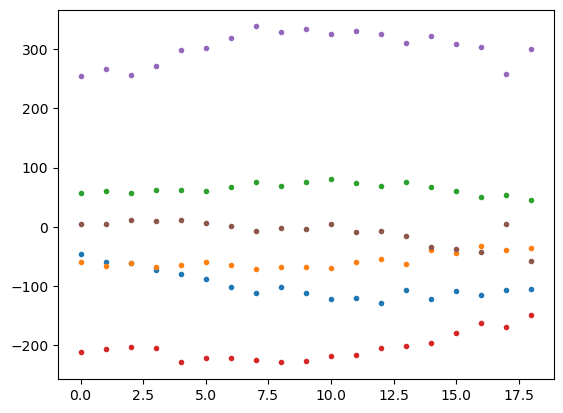

In [65]:
for i in range(len(ind)):
    plt.plot(rvmat_test[:,i],'.')
#plt.plot(rvmat[:,1],'.')
#plt.plot(rvmat[:,2],'.')
#plt.plot(rvmat[:,3],'.')
#plt.plot(rvmat[:,4],'.')
#plt.plot(rvmat[:,5],'.')
#plt.plot(rvmat[:,6],'.')

#plt.ylim((-500,500))
#plt.legend([46,47,45,44,48])
print(ofiles)

In [66]:
from scipy.stats import median_abs_deviation as mad

stdarr = np.zeros(nspec)
## std of rvmat
for i in range(nspec):
    stdarr[i] = mad(rvmatrix[:,i]/0.6745)
    print(mad(rvmatrix[:,i])/0.6745)
    print(np.std(rvmatrix[:,i]))
    print()
    #print(0.6745**2)

21.250308870768464
23.23096857413789

8.401284902396833
12.184643115607635

10.130961205831484
9.426939583161973

20.756115641215715
22.728660944200055

25.945144551519643
27.29034353224095

11.119347664936953
19.674619266325177



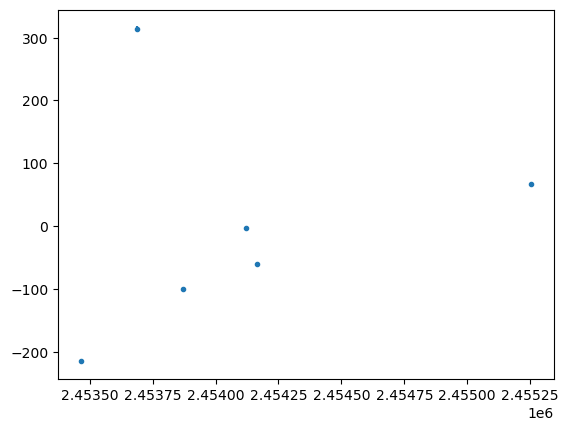

In [67]:
plt.errorbar(bmjd,rvarr,yerr=errarr,fmt='.')
#stdarr = np.zeros(nspec)
#plt.errorbar(bmjd,rvarr,yerr=errarr,fmt='.')
#plt.errorbar(np.mod((jdarr+240000.5-2459339.037)/16.436,1),rvarr,yerr=errarr,fmt='.')
#plt.errorbar(np.mod((jdarr2-2459339.037269)/16,1),rvarr,yerr=errarr,fmt='.')
#plt.xlim([2458200,2458300])
x = np.linspace(0, 1, 1000)  # 在[0,1]区间内生成1000个均匀间隔的点

y = -100*np.sin(2 * np.pi * x) 
#plt.plot(x, y)


In [194]:
jdarr

array([58225.26931256, 58226.26356286, 58227.25878406, 58228.27372636,
       58229.27899436, 58230.23242537, 58231.23641598, 58232.33478888,
       58233.22657553, 58235.01793129, 58235.19902368, 58236.25616296,
       58237.32502073, 58238.15852023, 58238.29627494, 58616.22888577,
       58619.2911333 , 58620.11963692, 58622.0813847 ])

In [195]:
#np.savez('wasp189rv-sorted.npz',jdarr=jdarr,rvarr=rvarr,errarr=errarr,stdarr=stdarr,wijarr=wijarr,rvmatrix=rvmatrix)

In [196]:
for i in range(nspec):
    hdu = fits.open(fitsdir+fitsfiles[i])
    header = hdu[0].header
    print(header['DATE-OBS'])

2019-05-16
2018-04-30
2018-04-17
2018-04-22
2018-04-18
2019-05-13
2018-04-24
2018-04-21
2018-04-19
2019-05-19
2018-04-23
2018-04-20
2018-04-29
2018-04-27
2018-04-28
2018-04-27
2019-05-17
2018-04-25
2018-04-30


So it does look like the last two data points are the in-transit ones.

But the JDs don't look right...\
Start - mid - end:\
10073.2685\
10073.3587\
10073.4489

https://astro.swarthmore.edu/transits/print_transits.cgi?single_object=0&ra=&dec=&epoch=&period=&duration=&depth=&target=&observatory_string=40.393333%3B-242.425%3BAsia%2FShanghai%3BBeijing+XingLong+Observatory%2C+China&use_utc=0&observatory_latitude=40.393333&observatory_longitude=-242.425&timezone=Asia%2FShanghai&start_date=05-08-2023&days_to_print=1&days_in_past=0&minimum_start_elevation=30&and_vs_or=or&minimum_end_elevation=30&minimum_ha=-12&maximum_ha=12&baseline_hrs=1&show_unc=1&minimum_depth=0&maximum_V_mag=7&target_string=WASP-189&print_html=1&twilight=-12&max_airmass=2.4

In [197]:
jdarr2 = np.zeros(nspec)
for i in range(nspec):
    hdu = fits.open(fitsdir+fitsfiles[i])
    header = hdu[0].header
    ut_time = header['DATE-OBS']
    print(ut_time)
    # Create a Time object with the UT time and format
    time = Time(ut_time, format='isot', scale='utc')

    # Convert to JD (Julian Date)
    jdarr2[i] = time.jd - 8.0/24.0 + 405.0/3600./24.0 # UTC is 8 hours behind Beijing time, plus 1800s exposure time

jdarr2 = np.sort(jdarr2)
jdarr2

2019-05-16
2018-04-30
2018-04-17
2018-04-22
2018-04-18
2019-05-13
2018-04-24
2018-04-21
2018-04-19
2019-05-19
2018-04-23
2018-04-20
2018-04-29
2018-04-27
2018-04-28
2018-04-27
2019-05-17
2018-04-25
2018-04-30


array([2458225.17135417, 2458226.17135417, 2458227.17135417,
       2458228.17135417, 2458229.17135417, 2458230.17135417,
       2458231.17135417, 2458232.17135417, 2458233.17135417,
       2458235.17135417, 2458235.17135417, 2458236.17135417,
       2458237.17135417, 2458238.17135417, 2458238.17135417,
       2458616.17135417, 2458619.17135417, 2458620.17135417,
       2458622.17135417])

In [419]:
print(delw/5500.0*c)

NameError: name 'delw' is not defined

In [51]:
np.savez('wasp189rv-sorted-newjd.npz',jdarr=jdarr2,rvarr=rvarr,errarr=errarr,stdarr=stdarr,wijarr=wijarr,rvmatrix=rvmatrix)